In [ ]:
comp='shannon'
meas = 'silta9a'

%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt
import os 
import pandas as pd
import yaml

import scresonators.measurement.handy as hy
import scresonators.measurement.helpers as helpers
import scresonators.fitting.ana_tls as ana_tls

helpers.config_figs()

if comp=='shannon':
    pth_base ='/Users/sph/Library/CloudStorage/GoogleDrive-circuitqed@gmail.com/'
elif comp=='bf1':
    pth_base='G:/'

cloud_folder = os.path.join(pth_base, 'My Drive/Projects/Materials')
data_folder = os.path.join(cloud_folder, 'Data')
img_pth = os.path.join(cloud_folder, 'Outputs/Resonators')

In [ ]:
with open('mini2.yml', 'r') as file:
    sample_dict = yaml.safe_load(file)

matching_keys = [key for key, items in sample_dict.items() for item in items['meas'] if item == meas]
sample = matching_keys[0] if matching_keys else None

ind = sample_dict[sample]['meas'].index(meas)
params = sample_dict[sample]
nsets = len(params['dir'])

data_pth = [os.path.join(pth_base, data_folder, params['pth'][0], dir) for dir in params['dir']]
img_name = params['pth'][ind][0:-1] + params['meas'][ind]

0


['fit_results_freq_4089MHz.csv', 'fit_results_freq_5056MHz.csv', 'fit_results_freq_5454MHz.csv', 'fit_results_freq_6319MHz.csv', 'fit_results_freq_7724MHz.csv']


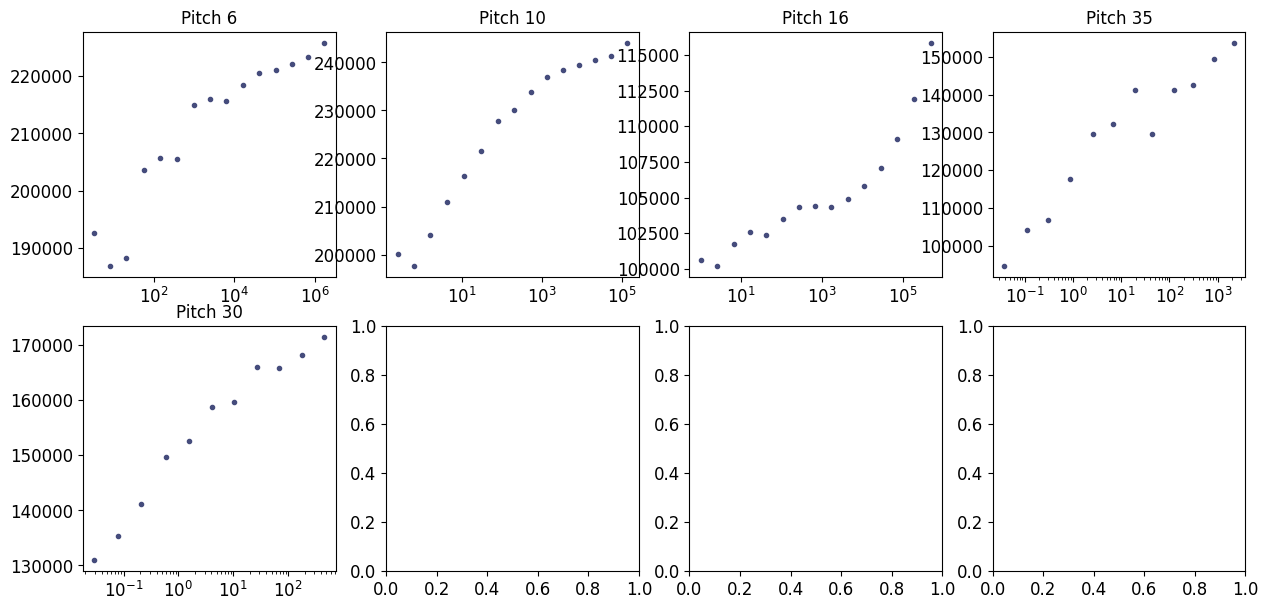

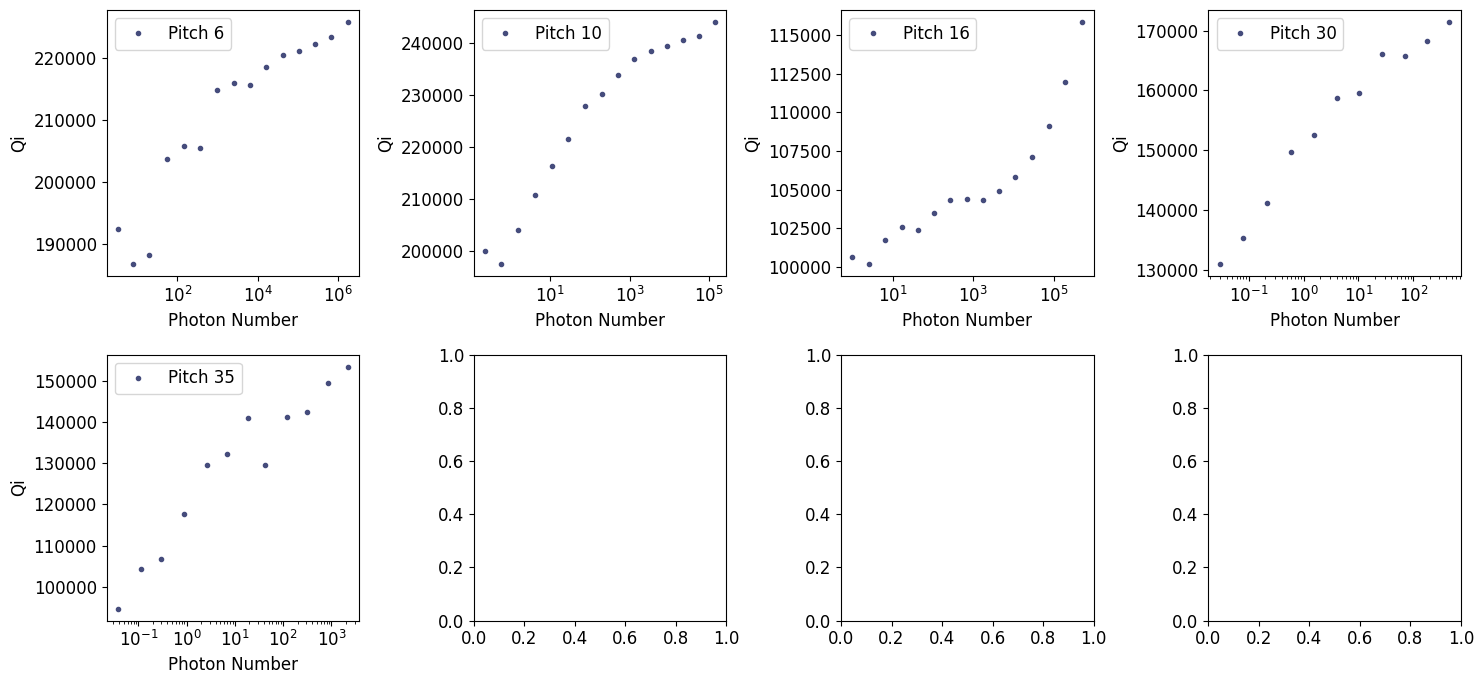

In [19]:
fig, ax = plt.subplots(2,4, figsize=(15, 7))
ax = ax.flatten()
df_full = pd.DataFrame()
csv_files_in_dir = [f for f in os.listdir(data_pth[0]) if f.startswith('fit_results') and f.endswith('.csv')]
csv_files_in_dir.sort()
print(csv_files_in_dir)
# jpa 
coef = np.array([15, 16, 18, 27, 26, 29, 25.75])+1

# slab
coef = np.array([4,7.75,10,15,16,18.2])

#coef = np.array([0, 0, 0, 0, 0, 0, 0])  # No correction for slab resonators
for i, csv_file in enumerate(csv_files_in_dir):
    df= pd.DataFrame()
    photon_max = []
    for j, d in enumerate(data_pth): 
        file_path = os.path.join(d, csv_file)
        df_tmp = pd.read_csv(file_path)
        df_tmp['ind']=j
        
        if j>0:
            df_tmp['photon_number'] = df_tmp['photon_number']*10**(-coef[i]/20)
        df=pd.concat([df, df_tmp], ignore_index=True)
        try: 
            ax[i].semilogx(df_tmp['photon_number'], df_tmp['q_internal'],'.')
            ax[i].set_title(f'Pitch {params["pitch"][i]}')
        
        except: 
            pass
        #photon_range.append([df_tmp['photon_number'].max(), df_tmp['photon_number'].min()])
        photon_max.append(df_tmp['photon_number'].max())
    #print(photon_max)
    power_order = np.argsort(photon_max)
    df = df[(df['ind'] == power_order[0]) | (df['photon_number'] >= photon_max[power_order[0]])]
    # filtered_df = df[df['ind']] == sorted_inds[1]
    # filtered_df = filtered_df[filtered_df['photon_number'] < np.min(photon_range)]
    # print(filtered_df)
    

    df['pitch']=params['pitch'][i]
    df['target_freq']=params['target_freq'][i]
    df['resonator_id'] = i
    df['temp']=0.04
    df_full = pd.concat([df_full, df], ignore_index=True)

df_full = df_full.sort_values(by='pitch')


fig, ax = plt.subplots(2,4, figsize=(15, 7))
ax = ax.flatten()
grouped = df_full.groupby('pitch')
for i, (pitch, group) in enumerate(grouped):
    ax[i].semilogx(group['photon_number'], group['q_internal'], '.', label=f'Pitch {pitch}')
    #ax[i].set_title(f'Pitch {pitch}')
    ax[i].set_xlabel('Photon Number')
    ax[i].set_ylabel('Qi')
    ax[i].legend()
fig.tight_layout()
coef = [0, 25]


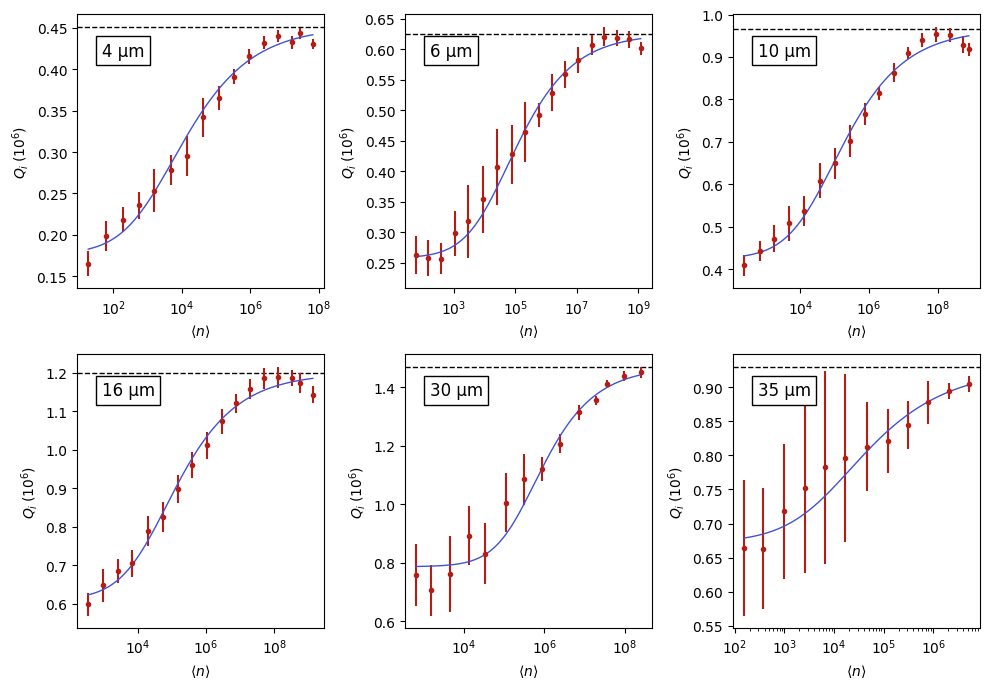

In [10]:
# for slab 
max_photon = [1e8, 1.2e9, 8e8, 1.5e9, 2e9, 1e7]
min_photon = [1, 1, 1, 1, 1, 1]
exclude = [None] * len(max_photon)  # Exclude all data points
exclude[4]=[11]
q_other_bounds = [np.inf, np.inf, np.inf, np.inf, 1.47e6, 0.93e6]  # Example bounds for Qoth
# for jpa 
# max_photon = [3e7, 0.9e6, 5e9, 5e9, 5e9, 2e10, 2e10]
# min_photon = [0.2, 1, 1, 1, 1, 0.2,0.2]
# q_other_bounds = [np.inf, np.inf, np.inf, np.inf, np.inf, 1.5e6, 0.265e6]  # Example bounds for Qoth

# max_photon = [2e7, 5e5, 1e10, 5e9, 5e9, 2e10, 2e10]
# min_photon = [0, 0, 0, 0, 0, 0, 0]

#min_photon = [300, 1, 1, 1, 240000, 1000]
#params, 
#cfg = ana_tls.fit_qi2(df_full, img_pth, name=img_name)
cfg = ana_tls.fit_qi2(df_full, img_pth, name=img_name, max_photon_vec=max_photon, min_photon_vec=min_photon, exclude=exclude, q_other_bounds=q_other_bounds, show_all=False, wide=False) 
#cfg = ana_tls.fit_qi2(df_full, img_pth, name=img_name, max_photon_vec=max_photon, min_photon_vec=min_photon, show_all=True, wide=False, q_other_bounds=q_other_bounds) 

/Users/sph/Documents/Git/scresonators/fit_resonator/../../scresonators/fit_resonator/ana_tls.py:584: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].set_ylabel("$Q_c \; (10^6)$")


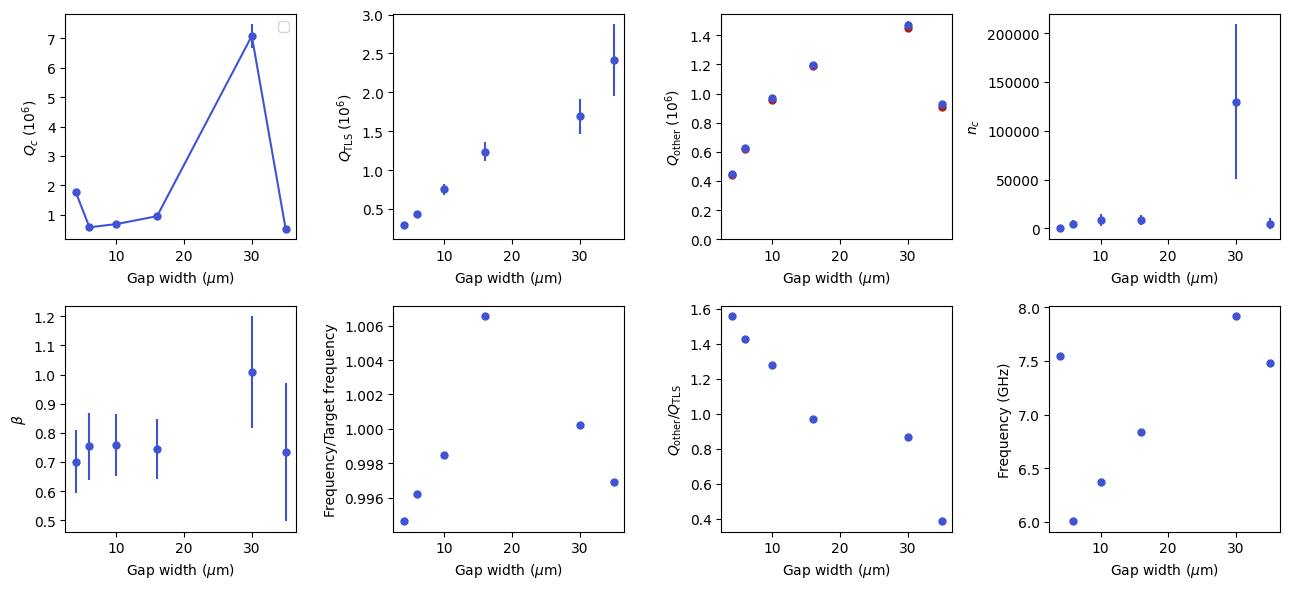

In [12]:
ana_tls.plot_res_pars([cfg], [''],img_pth, name=img_name)
hy.save_np(cfg, img_pth+'Text/' +params['pth'][ind][0:-1] +params['meas'][ind] + '.yml')

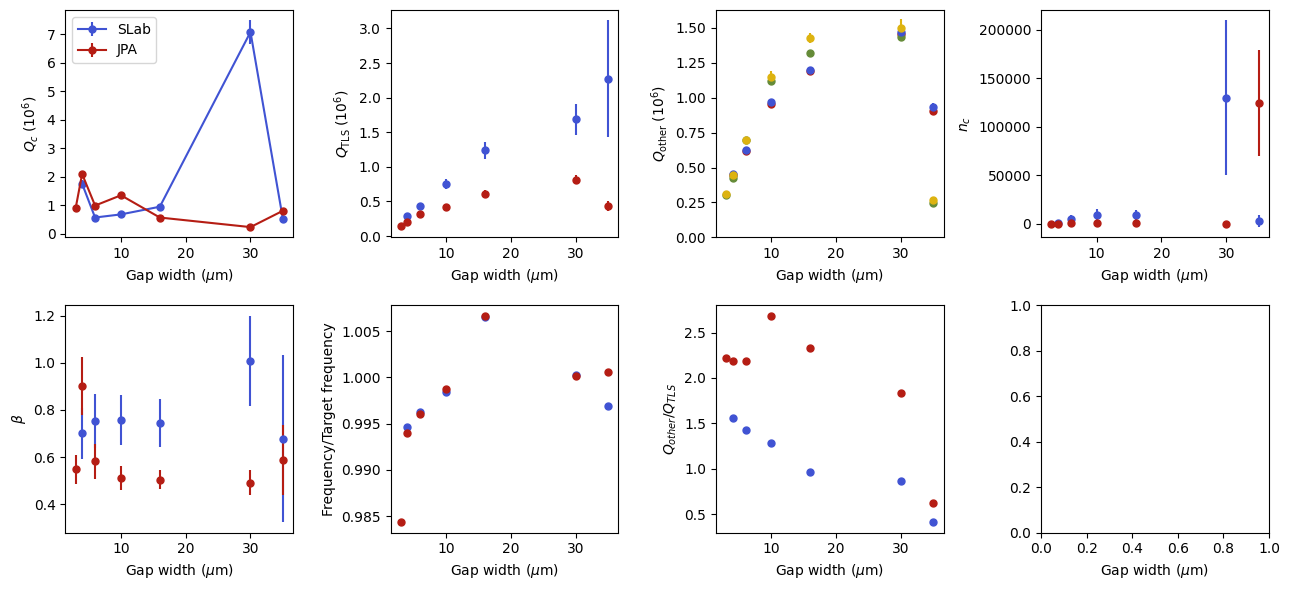

In [284]:
pnames = ['20250728-ResSilTa-Aggron-Slabsilta8_slab' ,'20250728-ResSilTa-Aggron-JPAsilta8_jpa']
labs = ['SLab', 'JPA'] 
plist =[]
for p in pnames:
    plist.append(hy.load(img_pth +'Text/'+ p + '.yml'))

ax=ana_tls.plot_res_pars(plist, labs,img_pth, name=pnames[0]+'_' +pnames[1])
#ResonatorPlotter.plot_res_pars(plist, labs,img_pth)